<a href="https://colab.research.google.com/github/edongdongchen/EI/blob/main/ei_demo_cs_usps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from torch.utils.data import DataLoader

import os
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# define an inverse problem e.g. Compressed Sensing (CS)
# where the forward operator A is a random projection matrix
class CS():
  def __init__(self, d, D, img_shape, dtype=torch.float, device='cuda:0'):
    self.img_shape = img_shape
    fname = './dataset/forw_cs_{}x{}.pt'.format(d, D)
    if os.path.exists(fname):
      A, A_dagger = torch.load(fname)
    else:
      A = np.random.randn(d, D) / np.sqrt(d)
      A_dagger = np.linalg.pinv(A)
      torch.save([A, A_dagger], fname)
      print('CS matrix has been created and saved at {}'.format(fname))
    self._A = torch.from_numpy(A).type(dtype).to(device)
    self._A_dagger = torch.from_numpy(A_dagger).type(dtype).to(device)

  def A(self, x):
    y = torch.einsum('in, mn->im', x.reshape(x.shape[0], -1), self._A)
    return y

  def A_dagger(self, y):
    N, C, H, W = y.shape[0], self.img_shape[0], self.img_shape[1], self.img_shape[2]
    x = torch.einsum('im, nm->in', y, self._A_dagger)
    x = x.reshape(N, C, H, W)
    return x

Plot the compressed measurement $y$ and its Groundtruth $x$. 

  0%|          | 0/1831726 [00:00<?, ?it/s]

CS matrix has been created and saved at ./dataset/forw_cs_64x256.pt
x (GT): torch.Size([1, 16, 16])	y: torch.Size([1, 64])


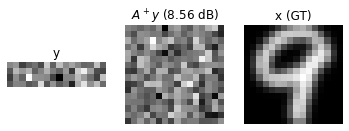

In [3]:
dtype = torch.float
device = 'cuda:0'
batch_size = 1

# test set
test_dataset = USPS(root='./dataset/', train=False, download=True, transform=transforms.ToTensor())
test_dataloader=DataLoader(test_dataset,batch_size=1,shuffle=False)

# define a CS (4x) operator
physics = CS(64, 256, [1,16,16], dtype, device)
# ground-truh
x = test_dataset[0][0].type(dtype).to(device) #torch.Size([1, 1, 16, 16])
# measurement
y = physics.A(x)

print(f'x (GT): {x.shape}\ty: {y.shape}')

def torch2img(x):
  return x.squeeze().detach().cpu().numpy()
  
def cal_psnr(a, b):
  alpha = np.sqrt(a.shape[-1]*a.shape[-2])
  psnr = 20*torch.log10(alpha*torch.norm(b, float('inf'))/torch.norm(b-a, 2))
  return psnr.detach().cpu().numpy()

ATy = physics.A_dagger(y)
# have a look at the cs measurement y, A^+y, and the ground-truth x.
plt.subplot(1,3,1)
plt.imshow(torch2img(y.view(1,1,4,16)), cmap='gray'), plt.title('y'), plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(torch2img(ATy), cmap='gray'), plt.title(r'$A^+y$ ({:.2f} dB)'.format(cal_psnr(ATy, x))), plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(torch2img(x), cmap='gray'), plt.title('x (GT)'), plt.axis('off')
plt.show()



---
To learn the reconstruction function $f:y\rightarrow x$ from only the measurements set $\{y\}$, we assume the signal set $\mathcal{X}$ is invariant to a groups of transformations $T_g$ related to a group 𝒢, where $T_gT_g^{\top}=I$. For example:
    
    - natural images are shift invariant.
    - in CT/MRI data, organs can be imaged at different angles making the problem invariant to rotation.

Key observations: 
- Invariance provides access to implicit operators $A_g=AT_g$ with potentially different range spaces: $Ax=AT_gT_g^{\top}x=A_g\tilde{x}$  where $A_g=AT_g$ and $\tilde{x}=T_g^{\top}x$.

- The composition $f\circ A$ is equivariant to the group of transformations ${T_g}$:  $f(AT_gx)=T_gf(Ax)$


# **EI:** All you need is to:
  * Define:
1. define a transformation group $\{T_g\}$ based on the certain invariances to the signal set.
2. define a neural reconstruction function $f_\theta: y\rightarrow x$, *e.g.* $f_\theta=G_\theta\circ A^{\dagger}$ and $G_\theta$ could be a UNet-like encoder-decoder net.

  * Calculate:
1. calculate $x^{(1)} = f_\theta(y)$ as the estimation of $x$.
2. calculate $x^{(2)} = T_g(x^{(1)})$ by transforming $x^{(1)}$.
2. calculate $x^{(3)} = f_\theta(Ax^{(2)})$ by reconstructing $x^{(2)}$ from its measurement $Ax^{(2)}$.


  * Finaly, learn the reconstruction function $f_\theta$ by solving: 
$\arg\min\limits_\theta\mathbb{E}_{y,g}\{\mathcal{L}(Ax^{(1)},y) +\lambda\mathcal{L}(x^{(2)},x^{(3)})\}$.

In [4]:
# define a transformation group (random shift)
import random
class Shift():
  def __init__(self, n_trans):
    self.n_trans = n_trans
  def apply(self, x):
    H, W = x.shape[-2], x.shape[-1]
    assert self.n_trans <= H - 1 and self.n_trans <= W - 1, 'n_shifts should less than {}'.format(H-1)

    shifts_row = random.sample(list(np.concatenate([-1*np.arange(1, H), np.arange(1, H)])), self.n_trans)
    shifts_col = random.sample(list(np.concatenate([-1*np.arange(1, W), np.arange(1, W)])), self.n_trans)

    x = torch.cat([x if self.n_trans == 0 else torch.roll(x, shifts=[sx, sy], dims=[-2,-1]).type_as(x)
              for sx, sy in zip(shifts_row, shifts_col)], dim=0)
    return x

In [5]:
# define residual unet
class UNet(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, compact=4, residual=True, circular_padding=True, cat=True):
    super(UNet, self).__init__()
    self.name = 'unet'
    self.residual = residual
    self.cat = cat

    self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.Conv1 = conv_block(ch_in=in_channels, ch_out=64, circular_padding=circular_padding)
    self.Conv2 = conv_block(ch_in=64, ch_out=128)
    self.Conv3 = conv_block(ch_in=128, ch_out=256)
    self.Conv4 = conv_block(ch_in=256, ch_out=512)

    self.Up4 = up_conv(ch_in=512, ch_out=256)
    self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

    self.Up3 = up_conv(ch_in=256, ch_out=128)
    self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

    self.Up2 = up_conv(ch_in=128, ch_out=64)
    self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

    self.Conv_1x1 = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
  
  def forward(self, x):
    # encoding path
    cat_dim = 1
    input = x
    x1 = self.Conv1(input)

    x2 = self.Maxpool(x1)
    x2 = self.Conv2(x2)

    x3 = self.Maxpool(x2)
    x3 = self.Conv3(x3)

    d3 = self.Up3(x3)
    if self.cat:
        d3 = torch.cat((x2, d3), dim=cat_dim)
        d3 = self.Up_conv3(d3)

    d2 = self.Up2(d3)
    if self.cat:
        d2 = torch.cat((x1, d2), dim=cat_dim)
        d2 = self.Up_conv2(d2)

    d1 = self.Conv_1x1(d2)

    out = d1+x if self.residual else d1
    return out

class conv_block(nn.Module):
  def __init__(self, ch_in, ch_out, circular_padding=False):
    super(conv_block, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True,
                  padding_mode='circular' if circular_padding else 'zeros'),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True),
        nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    x = self.conv(x)
    return x

class up_conv(nn.Module):
  def __init__(self, ch_in, ch_out):
    super(up_conv, self).__init__()
    self.up = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.up(x)
    return x

Define the Neural Reconstruction Funtion $f_\theta=G_\theta\circ A^\dagger$:

In [6]:
G = UNet().to(device)
f = lambda y: G(physics.A_dagger(y))

Define the transformation group $\{T_g\}$:


In [7]:
T = Shift(n_trans=2) # random shift: return n_trans=2 randomly shifted versions of the input

**Start Training:**

In [ ]:
from google.colab import drive
# from skimage import io
drive.mount('/content/drive')

In [24]:
# Equivariant Imaging
# note: the below hyper-parameters value is just for an example and may not be the best setting.
lr = 5e-4
wd = 1e-8
batch_size=8
epochs = 30
ckp_interval = 100
alpha = 10 # equivariance strength


dataloader=DataLoader(USPS(root='./dataset/',train=True,download=True, transform=transforms.ToTensor()),batch_size=batch_size,shuffle=True)
now = lambda: datetime.now().strftime('%y-%m-%d-%H:%M:%S')

def train(alpha=alpha):
  optimizer = torch.optim.Adam(G.parameters(), lr=lr, weight_decay=wd)
  mse = torch.nn.MSELoss().to(device)

  save_path = './ckp/{}_ei_cs4x_alpha_{}'.format(now(), alpha)
  os.makedirs(save_path, exist_ok=True)

  for epoch in range(epochs):
    loss_mc_epoch, loss_ei_epoch, loss_epoch, psnr_epoch = [], [], [], []
    for i, x in enumerate(dataloader):
      x = x[0].type(dtype).to(device) #torch.Size([4, 1, 16, 16])
      y = physics.A(x) #generate the measurements for training
      
      # only 4 lines of code for training EI
      # =========== EI start ============
      x1 = f(y) # reconstruction of the groundtruth x
      x2 = T.apply(x1) # transform
      x3 = f(physics.A(x2)) # reconstruct the transformed data
      loss = mse(physics.A(x1), y) + alpha * mse(x3, x2)
      # =========== EI end ============

      loss_epoch.append(loss.item())
      psnr_epoch.append(cal_psnr(x1, x)) # 

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print('{}\t[{}/{}]\tloss={:.4e}\tpsnr={:.3f}'.format(now(), epoch+1,epochs,np.mean(loss_epoch), np.mean(psnr_epoch)))
    
    # save the trained model
    if epoch % ckp_interval == 0 or epoch + 1 == epochs:
      state = {'epoch': epoch, 'state_dict': G.state_dict(), 'optimizer': optimizer.state_dict()} 
      torch.save(state, os.path.join(save_path, 'ckp_{}.pth.tar'.format(epoch)))
      torch.save(state, '/content/drive/My Drive/Thesis/EI-main/ckp/ct/ckp_29_ct.pth.tar')

train()


22-07-11-15:35:03	[1/30]	loss=1.1094e-02	psnr=12.903
22-07-11-15:35:23	[2/30]	loss=1.0888e-02	psnr=12.882
22-07-11-15:35:42	[3/30]	loss=1.0612e-02	psnr=12.925
22-07-11-15:36:01	[4/30]	loss=1.0599e-02	psnr=12.965
22-07-11-15:36:19	[5/30]	loss=1.0629e-02	psnr=12.901
22-07-11-15:36:38	[6/30]	loss=1.0467e-02	psnr=12.921
22-07-11-15:36:56	[7/30]	loss=1.0070e-02	psnr=12.986
22-07-11-15:37:16	[8/30]	loss=1.0191e-02	psnr=12.975
22-07-11-15:37:34	[9/30]	loss=9.9572e-03	psnr=13.024
22-07-11-15:37:53	[10/30]	loss=9.9113e-03	psnr=13.044
22-07-11-15:38:12	[11/30]	loss=9.8093e-03	psnr=13.049
22-07-11-15:38:30	[12/30]	loss=9.7311e-03	psnr=13.054
22-07-11-15:38:49	[13/30]	loss=9.7662e-03	psnr=13.055
22-07-11-15:39:08	[14/30]	loss=9.4948e-03	psnr=13.112
22-07-11-15:39:27	[15/30]	loss=9.4836e-03	psnr=13.099
22-07-11-15:39:45	[16/30]	loss=9.4681e-03	psnr=13.100
22-07-11-15:40:04	[17/30]	loss=9.2760e-03	psnr=13.157
22-07-11-15:40:23	[18/30]	loss=9.3595e-03	psnr=13.129
22-07-11-15:40:41	[19/30]	loss=9.1925

**Test** a trained EI model.

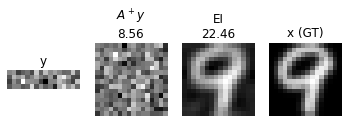

In [25]:
# Test
def test(net, ckp, ATy):
  checkpoint = torch.load(ckp, map_location=device)
  net.load_state_dict(checkpoint['state_dict'])
  net.to(device).eval()
  return net(ATy)

# load the trained EI model
ckp_ei = '/content/drive/My Drive/Thesis/EI-main/ckp/ct/ckp_29_ct.pth.tar' # replace the path with your trained model
unet = UNet().to(device)

# ground-truh
x = test_dataset[0][0].type(dtype).to(device) #torch.Size([1, 1, 16, 16])
# measurement
y = physics.A(x)
ATy = physics.A_dagger(y)
x_ei = test(unet, ckp_ei, ATy)

plt.subplot(1,4,1)
plt.imshow(torch2img(y.view(1,1,4,16)), cmap='gray'), plt.title('y'), plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(torch2img(ATy), cmap='gray'), plt.title(r'$A^+y$'+'\n{:.2f}'.format(cal_psnr(ATy, x))), plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch2img(x_ei), cmap='gray'), plt.title('EI\n{:.2f}'.format(cal_psnr(x_ei, x))), plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(torch2img(x), cmap='gray'), plt.title('x (GT)'), plt.axis('off')
plt.show()